In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
INPUT_PATH = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'

In [3]:
df = pd.read_csv(INPUT_PATH)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.shape

(50000, 2)

In [5]:
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
df.sentiment = df.sentiment.map({'positive': 1, 'negative': 0})

In [9]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [10]:
X, y = df.review, df.sentiment

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=7)

In [68]:
X_train.dtype

dtype('O')

In [71]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000,), (10000,), (40000,), (10000,))

In [72]:
cv = CountVectorizer()

In [73]:
X_train_sparse = cv.fit_transform(X_train.values)

In [74]:
# cv.vocabulary_ # indexes for each word

In [75]:
print('Num of unique words: ', len(cv.vocabulary_))

Num of unique words:  93195


In [76]:
X_test_sparse = cv.transform(X_test.values) # ignores new words, counts only those seen in train set

In [77]:
X_train_sparse.shape, X_test_sparse.shape

((40000, 93195), (10000, 93195))

In [78]:
X_train_sparse

<40000x93195 sparse matrix of type '<class 'numpy.int64'>'
	with 5466917 stored elements in Compressed Sparse Row format>

In [79]:
print('Total cells: ', 40000*93195)
print('Filled cells (sparse matrix): ', 5466917)
print('%: ', 5466917 / (np.prod(X_train_sparse.shape)))

Total cells:  3727800000
Filled cells (sparse matrix):  5466917
%:  0.0014665263694404206


# Only 0.14% of data is filled. Other entries are 0's.

# Modeling 

In [80]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score

In [81]:
np.bincount(y_train), np.bincount(y_test)

(array([20015, 19985]), array([4985, 5015]))

# We have balanced subsets

In [82]:
logit = LogisticRegression(random_state=7, n_jobs=-1)
sgd_logit = SGDClassifier(max_iter=25, random_state=7, n_jobs=-1)

# Convention: 10**6 observed samples - for divergence of the algorithm
- Let's choose (10**6 / n_train_samples) - look sklearn documentation of SGD.

In [83]:
10 ** 6 / X_train_sparse.shape[0]

25.0

In [87]:
%%time
logit.fit(X_train_sparse, y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CPU times: user 48 ms, sys: 58.2 ms, total: 106 ms
Wall time: 7.56 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(n_jobs=-1, random_state=7)

In [86]:
accuracy_score(y_test, logit.predict(X_test_sparse))

0.8849

In [88]:
%%time
sgd_logit.fit(X_train_sparse, y_train)

CPU times: user 1.03 s, sys: 236 ms, total: 1.27 s
Wall time: 905 ms


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=25, n_jobs=-1, random_state=7)

# x7 times faster!

In [89]:
accuracy_score(y_test, sgd_logit.predict(X_test_sparse))

0.8765

# Let's plot the most important features (words)

In [90]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(1, 1 + 2 * n_top_features),
        feature_names[interesting_coefficients],
        rotation=60,
        ha="right",
    );

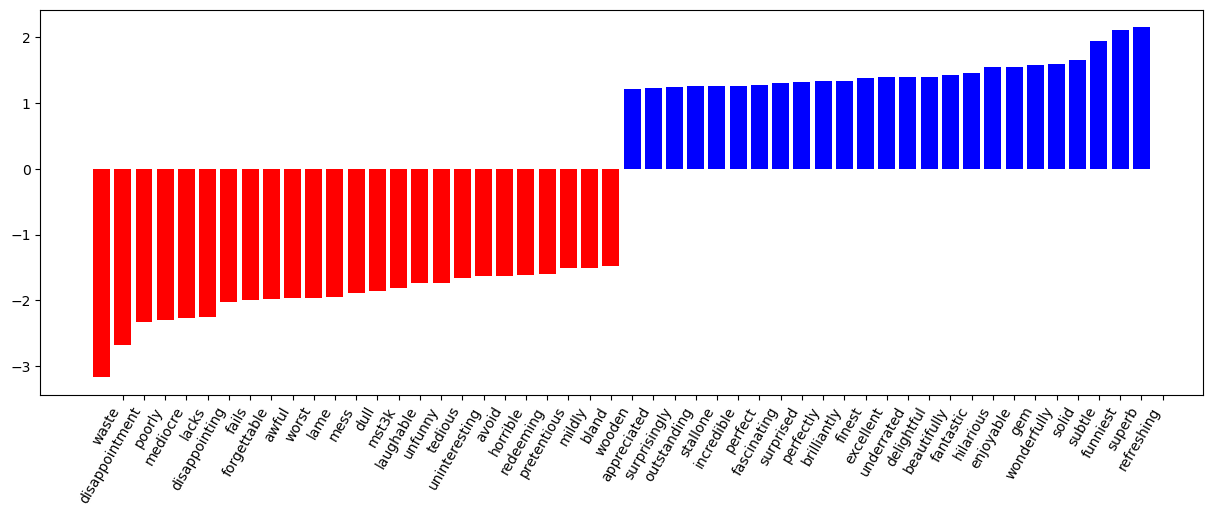

In [94]:
import matplotlib.pyplot as plt
visualize_coefficients(logit, cv.get_feature_names_out())

In [102]:
cv.get_feature_names_out

<bound method CountVectorizer.get_feature_names_out of CountVectorizer()>

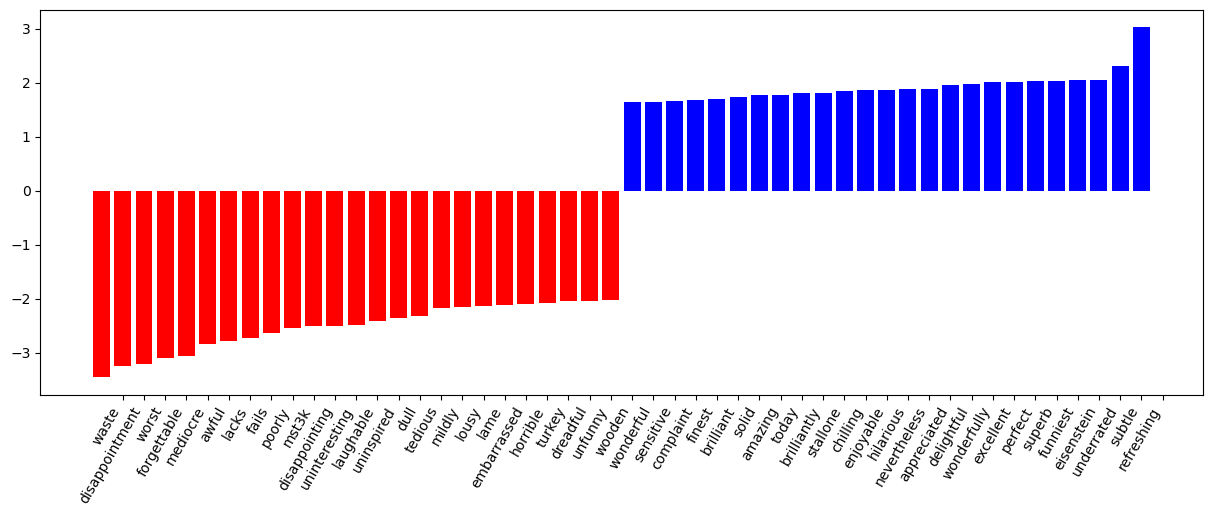

In [98]:
visualize_coefficients(sgd_logit, cv.get_feature_names_out())

# Let's try to improve the model with 2-grams (bigrams)

In [103]:
%%time

cv = CountVectorizer(ngram_range=(1, 2))
X_train_sparse = cv.fit_transform(X_train.values)

CPU times: user 44.3 s, sys: 1.27 s, total: 45.5 s
Wall time: 45.5 s


In [104]:
len(cv.vocabulary_)

2115233

In [112]:
%%time
X_test_sparse = cv.transform(X_test.values)

CPU times: user 7.04 s, sys: 47.6 ms, total: 7.09 s
Wall time: 7.09 s


In [113]:
X_train_sparse.shape, X_test_sparse.shape

((40000, 2115233), (10000, 2115233))

In [114]:
X_train_sparse

<40000x2115233 sparse matrix of type '<class 'numpy.int64'>'
	with 13890855 stored elements in Compressed Sparse Row format>

In [115]:
13890855 / np.prod(X_train_sparse.shape)

0.00016417641697155823

In [116]:
%%time

sgd_logit.fit(X_train_sparse, y_train)

CPU times: user 4.15 s, sys: 255 ms, total: 4.4 s
Wall time: 4.02 s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=25, n_jobs=-1, random_state=7)

In [117]:
accuracy_score(y_test, sgd_logit.predict(X_test_sparse))

0.9033

In [118]:
%%time

logit.fit(X_train_sparse, y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 173 ms, sys: 480 ms, total: 653 ms
Wall time: 1min 25s


LogisticRegression(n_jobs=-1, random_state=7)

In [119]:
accuracy_score(y_test, logit.predict(X_test_sparse))

0.9067

# Finding regularization coeffs for Logistic Regression. 
- Input: not sparsed data, since pipeline makes it sparsed itself.

In [121]:
%%time
from sklearn.pipeline import make_pipeline
# classifier
text_pipe_logit = make_pipeline(
    CountVectorizer(), LogisticRegression(n_jobs=-1, random_state=7)
)

text_pipe_logit.fit(X_train, y_train)
print(text_pipe_logit.score(X_test, y_test))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8849
CPU times: user 15.3 s, sys: 469 ms, total: 15.8 s
Wall time: 23.6 s


In [122]:
np.logspace(-5, 0, 6)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [125]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {"logisticregression__C": np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1)

grid_logit.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CPU times: user 14.1 s, sys: 2.48 s, total: 16.6 s
Wall time: 2min 13s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=7))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])})

In [126]:
grid_logit.best_params_, grid_logit.best_score_


({'logisticregression__C': 0.1}, 0.8908500311127847)

In [134]:
grid_logit.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_logisticregression__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [141]:
from matplotlib.pyplot import plot

def plot_grid_scores(grid, param_name):
    plot(
        grid.param_grid[param_name],
        grid.cv_results_['mean_test_score'],
        color="green",
        label="train",
    )
    plot(
        grid.param_grid[param_name],
        grid.cv_results_['mean_test_score'],
        color="red",
        label="test",
    )
    plt.legend();
    plt.xlabel('value of C')
    plt.ylabel('Error')

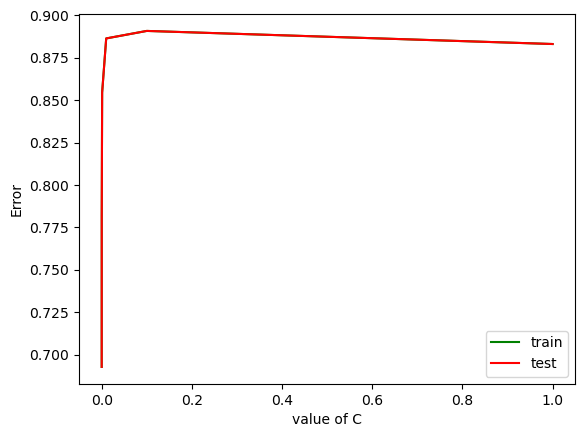

In [142]:
plot_grid_scores(grid_logit, "logisticregression__C")

# The same for SGD Lin Reg

In [144]:
%%time
# classifier
text_pipe_sgd_logit = make_pipeline(
    CountVectorizer(), SGDClassifier(max_iter=25, n_jobs=-1, random_state=7)
)

text_pipe_sgd_logit.fit(X_train, y_train)
print(text_pipe_sgd_logit.score(X_test, y_test))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.8765
CPU times: user 16.9 s, sys: 366 ms, total: 17.3 s
Wall time: 16.9 s


In [157]:
%%time
param_grid_svm = {'sgdclassifier__alpha': np.logspace(-5, 0, 6)}
grid_svm = GridSearchCV(text_pipe_sgd_logit, param_grid_svm, cv=3, n_jobs=-1)

grid_svm.fit(X_train, y_train);

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CPU times: user 15.7 s, sys: 2.61 s, total: 18.3 s
Wall time: 1min 49s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [158]:
grid_svm.best_params_, grid_svm.best_score_

({'sgdclassifier__alpha': 0.01}, 0.8871249829843316)